## Get calculated ESM2 pseudo-perplexity scores

In [386]:
import pandas as pd

esm2_scores_df = pd.read_csv('/Users/isabel/Documents/ESM2/ADA1_native_anc_output.csv')

more_scores = pd.read_csv('/Users/isabel/Documents/ESM2/ADA1_native_anc_output_2.csv')
yet_more = pd.read_csv('/Users/isabel/Documents/ESM2/some_anc_for_esm2_scoring.csv')

more_native = pd.read_csv('/Users/isabel/Documents/ESM2/new_native.csv')
more_anc = pd.read_csv('/Users/isabel/Documents/ESM2/other_paths.csv')
outgroups = pd.read_csv('/Users/isabel/Documents/ESM2/outgroups.csv')

additional_native = pd.read_csv('/Users/isabel/Documents/ESM2/new_native2.csv')

all_scores = pd.concat([esm2_scores_df, more_scores, yet_more, more_native, more_anc, outgroups, additional_native], ignore_index=True)


In [ ]:
# # write all these sequences to a fasta to re-score with different size ESM2 models

# with open('all_ADA1_seqs_for_esm2_scoring.fa', 'w') as file:
#     for index, row in all_scores.iterrows():
#         file.write(f">{row['sequence_id']}\n{row['sequence']}\n")


## Get ASR posterior probabilities for reconstructed sequences

In [387]:
import json
import numpy as np

# retrieve the dictionary of probabilities from PAML output
ml_probs_json = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/posterior_probabilities_no_gaps.json'

with open(ml_probs_json, "r") as f:
    probs_dict = json.load(f)

all_scores['ML prob'] = all_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

all_scores

,sequence_id,sequence,length,perplexity,mean_log_prob,pseudo_perplexity,mean_pll,pll,ML prob
0,node238,MASVSESPVFDLPKVELHVHLDGAIRPETILDLAKKRGIELPADTV...,355,1.123553,-0.116496,2.530428,-0.928389,-329.577928,0.854262
1,node239,MASTSQSPVFDLPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,358,1.173757,-0.160210,2.555415,-0.938215,-335.880819,0.870550
2,node240,MASMSQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,361,1.164467,-0.152263,2.466517,-0.902807,-325.913400,0.923670
3,node241,MSQSPVFDKPKVELHVHLDGAIKPETILYYGKKRGIPLPADTVEEL...,358,1.151685,-0.141226,2.329431,-0.845624,-302.733472,0.974070
4,node242,MSQTPAFNKPKVELHVHLDGAIKPETILYYGRKRGIPLPADTVEEL...,362,1.174702,-0.161014,2.414117,-0.881334,-319.042778,0.984431
...,...,...,...,...,...,...,...,...,...
191,node448,LLVLHESIANQAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGDG...,409,1.278040,-0.245327,4.243610,-1.445414,-591.174437,0.776858
192,A0A7L3PJ11_Xiphorhynchus_elegans,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,326,1.336332,-0.289929,5.041075,-1.617619,-527.343901,NaN
193,A0A673JME8_Sinocyclocheilus_rhinocerous,MAENNGKPAFDKPKIELHVHLDGAIRIKTIVEVAKRRGITLPVNGE...,362,1.210359,-0.190917,3.197630,-1.162410,-420.792358,NaN
194,A0A5J4NXI4_Paragonimus_westermani,MVSGDWIRTSESVWSEEPNKMHLNNDLKGIELHLHLDGAIRPTTLF...,360,1.337442,-0.290759,5.501315,-1.704987,-613.795380,NaN


## Get phylogenetic tree with ancestral labels

In [388]:
from Bio import Phylo

tree_file = "/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/ancestor_tree.txt"
tree = Phylo.read(tree_file, "newick")



In [389]:
def calc_branch_length_to_root_node(tree, node_num):

    # Find the target internal node by confidence label (actually the node number)
    target_node = None
    node_num = int(node_num)
    for clade in tree.find_clades():
        if hasattr(clade, 'confidence') and clade.confidence == node_num:
            target_node = clade
            break

    if target_node is None:
        print(f"Node with confidence {node_num} not found.")
        return None

    # Calculate distance from target node to root
    distance_to_root = tree.distance(tree.root, target_node)
    return distance_to_root

def calc_branch_length_to_root_leaf(tree, leaf_name):
    return tree.distance(tree.root, leaf_name)

all_scores['bl_to_root'] = all_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))


## Plot psuedo perplexity vs. distance from tree root vs. ML prob

### Plotting functions

In [390]:
import matplotlib.pyplot as plt

def get_node_labels_leaf_to_root(tree, leaf_name):
    """
    Retrieves the node labels along the path from a given leaf to the root.

    Parameters:
        tree (Phylo.BaseTree.Tree): The phylogenetic tree.
        leaf_name (str): The name of the leaf node.

    Returns:
        list: A list of node labels from leaf to root.
    """
    # Find the leaf
    leaf = tree.find_any(name=leaf_name)
    if leaf is None:
        print(f"Leaf {leaf_name} not found.")
        return []

    # Traverse from leaf to root
    labels = []
    path = tree.get_path(leaf)  # Returns list of clades from root to the leaf

    # Go in reverse to get from leaf to root
    for node in reversed(path):
        label = getattr(node, "confidence", None) or getattr(node, "name", None)
        labels.append(label)

    return ['node' + str(x) for x in labels[1:]]

def plot_evo_path(scores_df, tree, leaf_name, labels = False):
    these_nodes = get_node_labels_leaf_to_root(tree, leaf_name)

    # Subset the relevant data
    for_plot = scores_df[scores_df['sequence_id'].isin(these_nodes)]

    plt.figure(figsize=(12, 3))

    # Scatter plot with color representing ML probability
    scatter = plt.scatter(
        for_plot['bl_to_root'],
        for_plot['pseudo_perplexity'],
        c=for_plot['ML prob'],
        cmap='viridis_r',
        marker='o'
    )

    #Add labels for each point using the sequence_id
    if labels == True: 
        for i, row in for_plot.iterrows():
            plt.text(
                row['bl_to_root'],
                row['pseudo_perplexity'],
                row['sequence_id'],
                fontsize=9,
                ha='right',
                va='bottom'
            )

    # Add the leaf point in pink
    x = calc_branch_length_to_root_leaf(tree, leaf_name)
    y = scores_df[scores_df['sequence_id'] == leaf_name]['pseudo_perplexity'].to_list()[0]
    plt.scatter(x, y, color='deeppink', label='Leaf', zorder=10)

    # Add colorbar
    plt.colorbar(scatter, label='ASR Mean Posterior Probability')

    # Labels and layout
    plt.xlabel('Distance to Tree Root (subs/site)')
    plt.ylabel('ESM2 Pseudo Perplexity')
    plt.title(leaf_name)
    plt.tight_layout()
    plt.show()

### Results

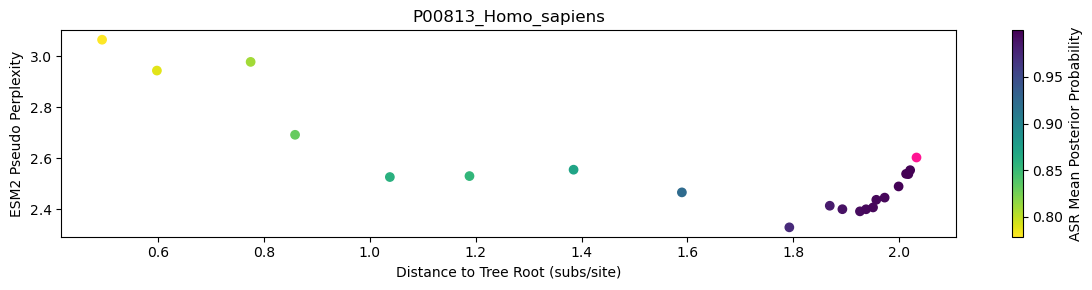

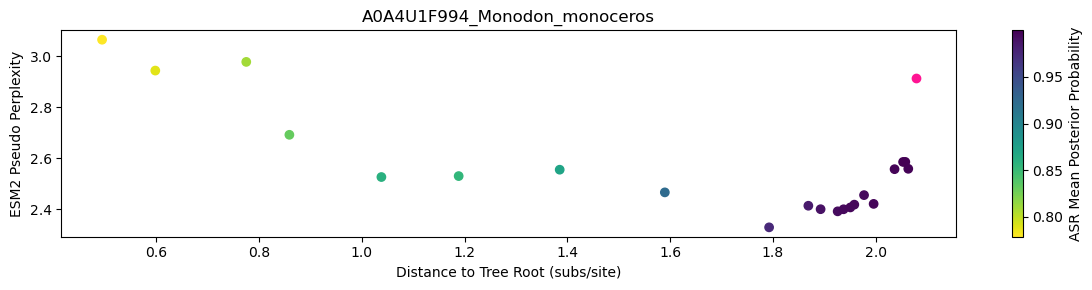

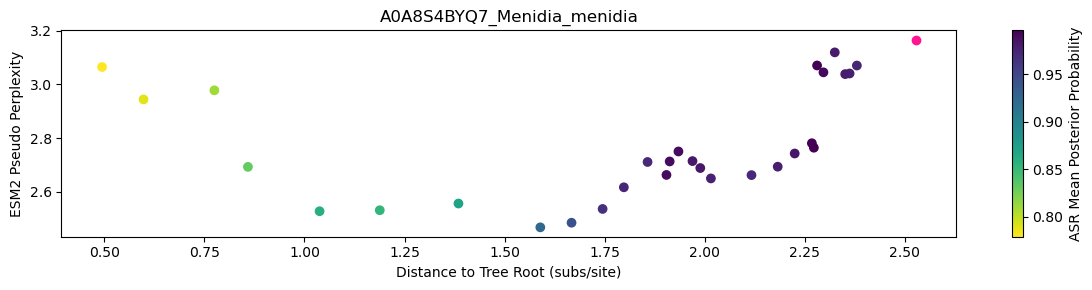

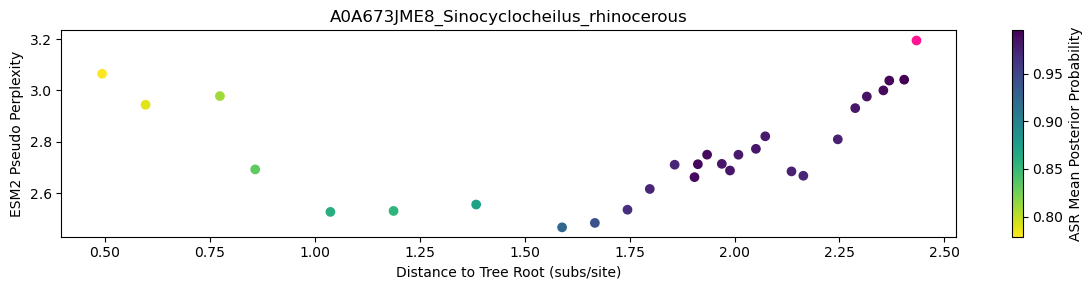

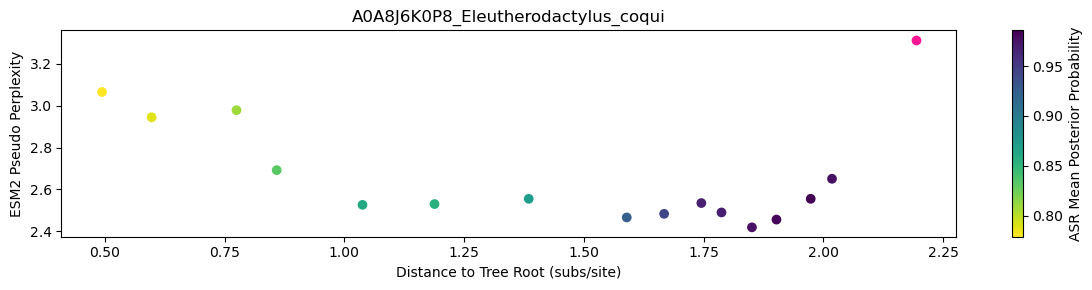

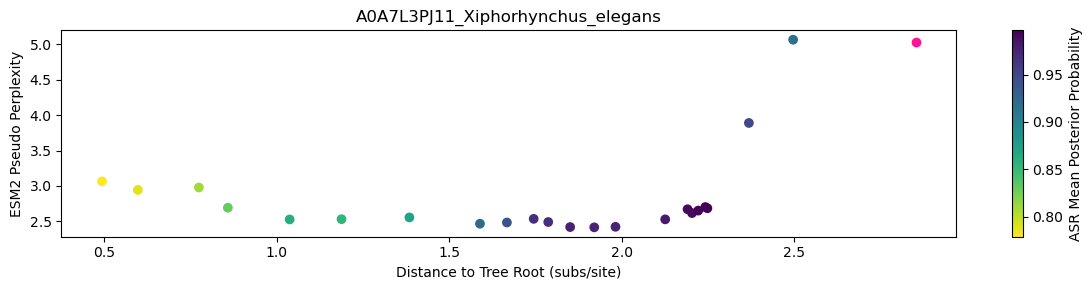

In [399]:
plot_evo_path(all_scores, tree, 'P00813_Homo_sapiens')
plot_evo_path(all_scores, tree, 'A0A4U1F994_Monodon_monoceros')
plot_evo_path(all_scores, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path(all_scores, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path(all_scores, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')
plot_evo_path(all_scores, tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')

## Repeat for smaller ESM2 models

### Loading data

In [ ]:
# # writing fasta for esm2 scoring

# # which nodes do i really need
# all_nodes = []
# extant_list = ['P00813_Homo_sapiens','A0A4U1F994_Monodon_monoceros', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A7L3PJ11_Xiphorhynchus_elegans']
# for entry in extant_list:
#     all_nodes.extend(get_node_labels_leaf_to_root(tree, entry))

# all_nodes.extend(extant_list)

# len(list(set(all_nodes)))

# # limit to just these for esm2 scoring on huge models

# with open('subset_ADA1_seqs_for_esm2_scoring.fa', 'w') as file:
#     for index, row in all_scores.iterrows():
#         if row['sequence_id'] in all_nodes:
#             file.write(f">{row['sequence_id']}\n{row['sequence']}\n")

# # limit to just human for biggest model
# human_only = get_node_labels_leaf_to_root(tree, 'P00813_Homo_sapiens')
# human_only.append('P00813_Homo_sapiens')

# with open('human_ADA1_seqs_for_esm2_scoring.fa', 'w') as file:
#     for index, row in all_scores.iterrows():
#         if row['sequence_id'] in human_only:
#             file.write(f">{row['sequence_id']}\n{row['sequence']}\n")

# # already tested some, get remaining names
# already_tested = huge_model_scores['sequence_id'].to_list()
# remaining_only = [x for x in all_nodes if x not in already_tested]

# with open('remaining_ADA1_seqs_for_esm2_scoring.fa', 'w') as file:
#     for index, row in all_scores.iterrows():
#         if row['sequence_id'] in remaining_only:
#             file.write(f">{row['sequence_id']}\n{row['sequence']}\n")





In [400]:
small_model_scores = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/all_ADA1_seqs_for_esm2_scoring_8M.csv')
med_model_scores = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/all_ADA1_seqs_for_esm2_scoring_35M.csv')
large_model_scores = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/all_ADA1_seqs_for_esm2_scoring_150M.csv')

df1 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_remaining_3B.csv')
df2 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_2more_3B.csv')
df3 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_just3_3B.csv')
df4 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/remaining_ADA1_3B.csv')
huge_model_scores = pd.concat([df1, df2, df3, df4])

small_model_scores['ML prob'] = small_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
small_model_scores['bl_to_root'] = small_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

med_model_scores['ML prob'] = med_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
med_model_scores['bl_to_root'] = med_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

large_model_scores['ML prob'] = large_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
large_model_scores['bl_to_root'] = large_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

huge_model_scores['ML prob'] = huge_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
huge_model_scores['bl_to_root'] = huge_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))




### Plotting functions

In [418]:
def plot_multiple_evo_lines(score_dfs_leaves_labels, tree, normalize=True):
    """
    Parameters:
        score_dfs_leaves_labels: list of tuples (scores_df, leaf_name, label_name)
        tree: Phylogenetic tree used to compute distances
        normalize: whether to normalize pseudo perplexity to the leaf value
    """
    plt.figure(figsize=(12, 3))
    
    n_lines = len(score_dfs_leaves_labels)
    colors = cm.rainbow_r(np.linspace(0, 1.0, n_lines))  # rainbow colormap

    for i, (scores_df, leaf_name, label_name) in enumerate(score_dfs_leaves_labels):
        color = colors[i]

        these_nodes = get_node_labels_leaf_to_root(tree, leaf_name)
        for_plot = scores_df[scores_df['sequence_id'].isin(these_nodes)].copy()
        for_plot.sort_values('bl_to_root', inplace=True)

        # Get leaf value
        leaf_value = scores_df[scores_df['sequence_id'] == leaf_name]['pseudo_perplexity'].to_list()[0]

        # Normalize if requested
        if normalize:
            for_plot['plot_value'] = for_plot['pseudo_perplexity'] / leaf_value
            y_leaf = 1.0
        else:
            for_plot['plot_value'] = for_plot['pseudo_perplexity']
            y_leaf = leaf_value

        x_leaf = calc_branch_length_to_root_leaf(tree, leaf_name)

        # Main line
        plt.plot(
            for_plot['bl_to_root'],
            for_plot['plot_value'],
            color=color,
            label=label_name
        )

        # Invisible marker at leaf
        plt.scatter(x_leaf, y_leaf, color=color, s=0.1, zorder=10)

        # Line to closest point
        closest_idx = (for_plot['bl_to_root'] - x_leaf).abs().idxmin()
        x_closest = for_plot.loc[closest_idx, 'bl_to_root']
        y_closest = for_plot.loc[closest_idx, 'plot_value']

        plt.plot(
            [x_leaf, x_closest],
            [y_leaf, y_closest],
            color=color
        )

    # Labels and layout
    plt.xlabel('Distance to Tree Root (subs/site)')
    y_label = 'Normalized Pseudo Perplexity\n(relative to leaf)' if normalize else 'Pseudo Perplexity'
    plt.ylabel(y_label)
    plt.title(leaf_name)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Results

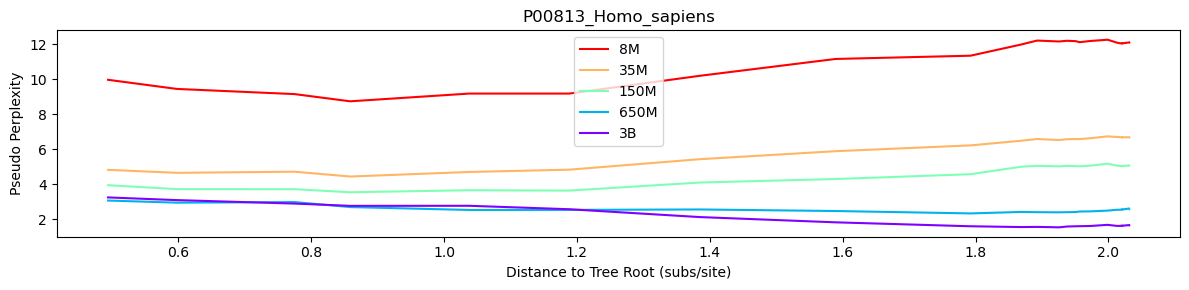

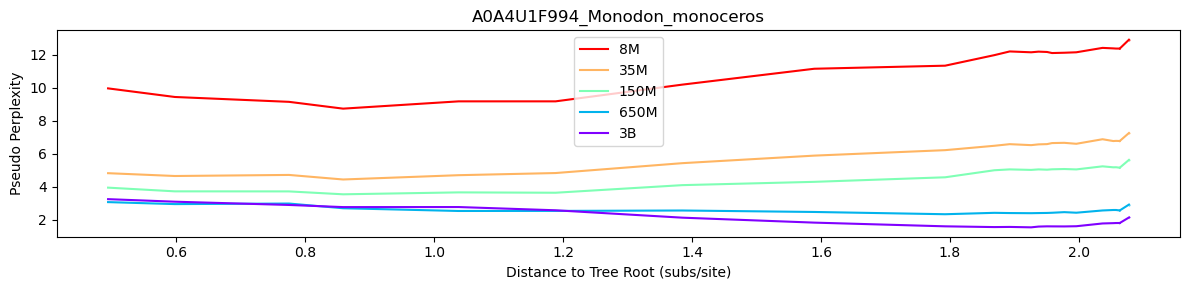

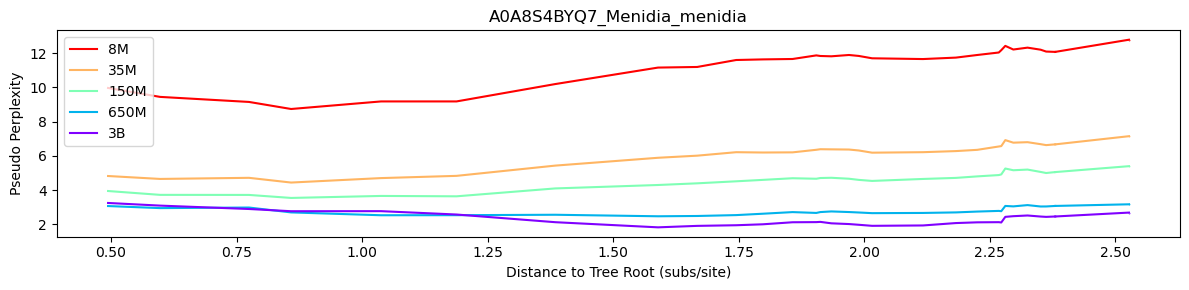

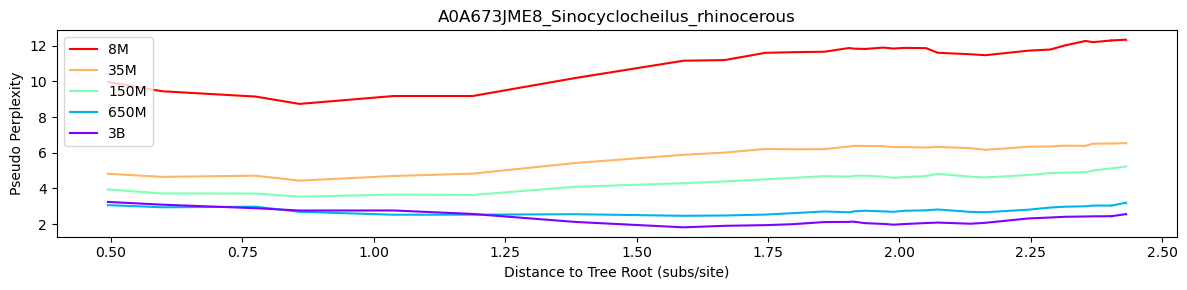

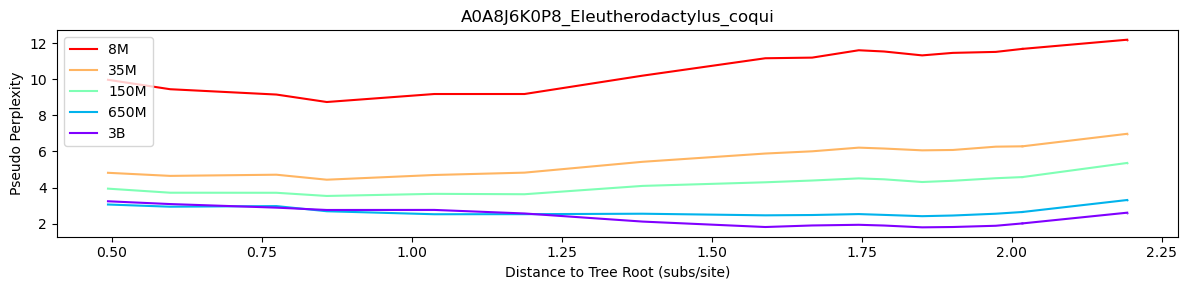

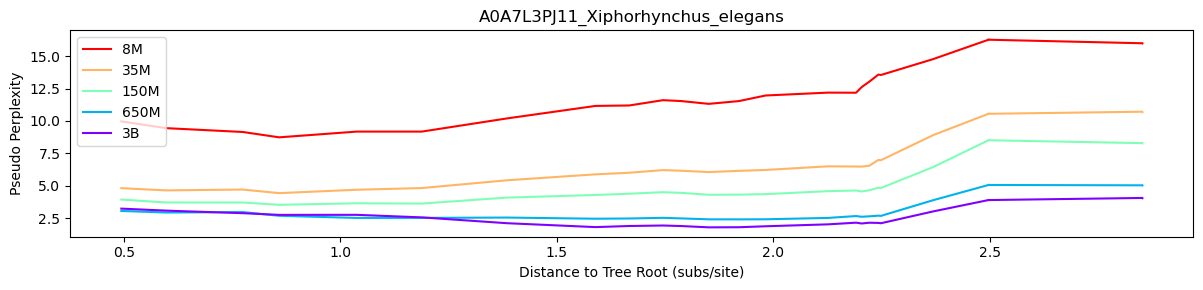

In [419]:
plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A4U1F994_Monodon_monoceros', '8M'),(med_model_scores, 'A0A4U1F994_Monodon_monoceros', '35M'),(large_model_scores, 'A0A4U1F994_Monodon_monoceros', '150M'),(all_scores, 'A0A4U1F994_Monodon_monoceros', '650M'),(huge_model_scores, 'A0A4U1F994_Monodon_monoceros', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '8M'),(med_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '35M'),(large_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '150M'),(all_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '650M'),(huge_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '3B')], tree, normalize = False)


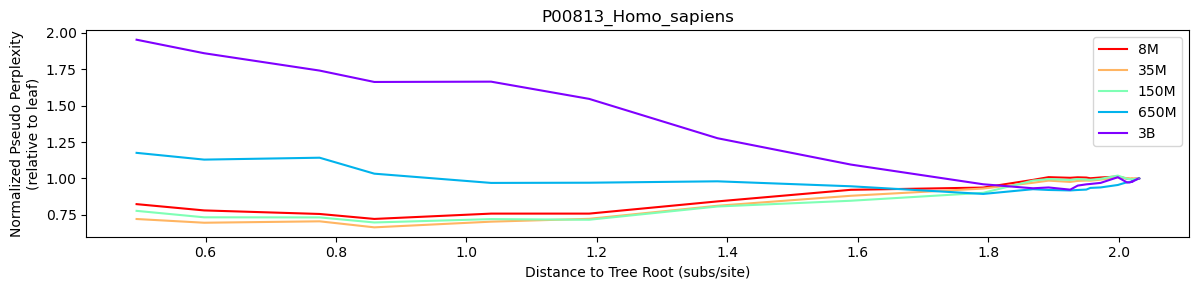

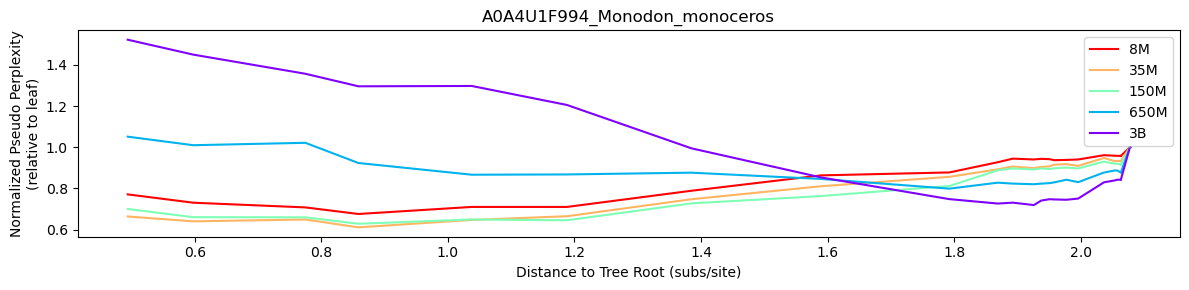

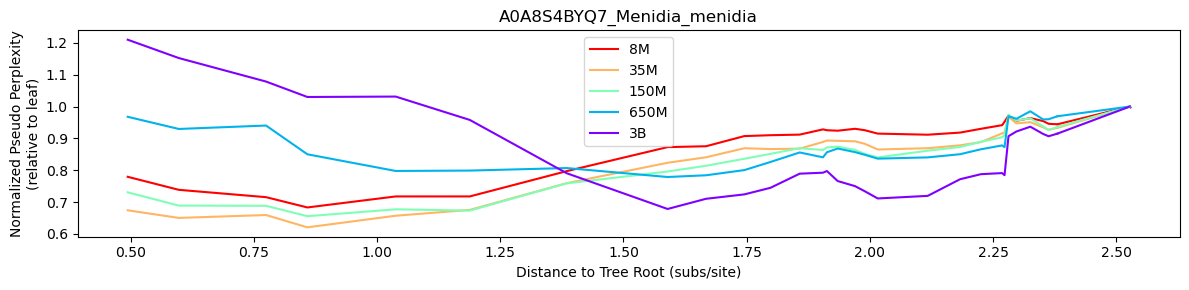

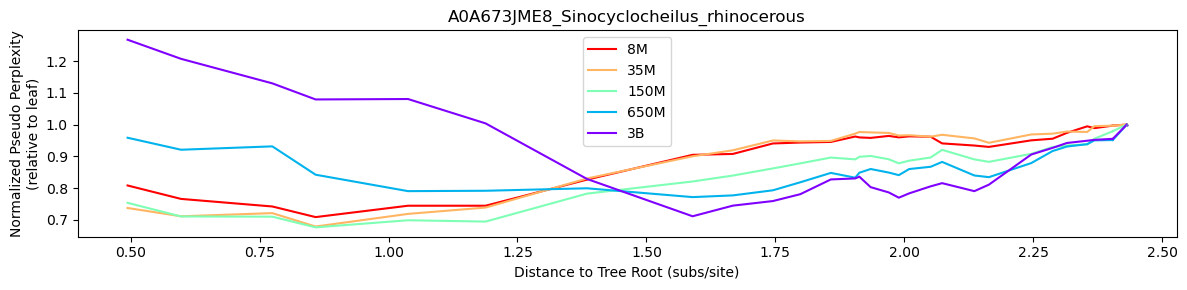

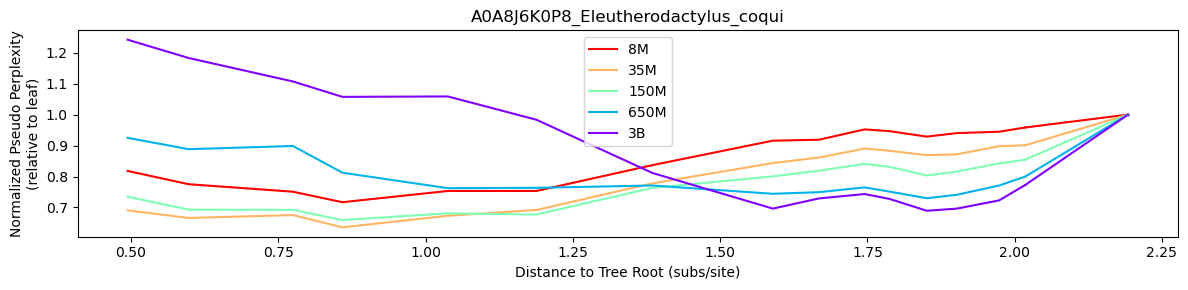

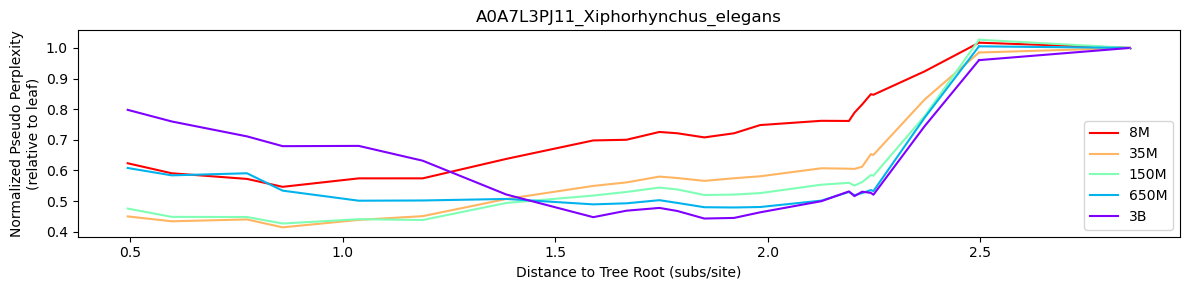

In [420]:

plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A4U1F994_Monodon_monoceros', '8M'),(med_model_scores, 'A0A4U1F994_Monodon_monoceros', '35M'),(large_model_scores, 'A0A4U1F994_Monodon_monoceros', '150M'),(all_scores, 'A0A4U1F994_Monodon_monoceros', '650M'),(huge_model_scores, 'A0A4U1F994_Monodon_monoceros', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '8M'),(med_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '35M'),(large_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '150M'),(all_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '650M'),(huge_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '3B')], tree)



## Compare ML to consensus ancestors

### Generate consensus sequences

In [ ]:
from Bio import SeqIO
from collections import Counter

def get_descendant_leaves(tree, node_num):
    node_num = int(node_num.replace('node',''))

    # Find the target internal node by confidence label
    target_node = None
    for clade in tree.find_clades():
        if getattr(clade, 'confidence', None) == node_num:
            target_node = clade
            break

    if target_node is None:
        print(f"Node with confidence {node_num} not found.")
        return []

    # Get all terminal (leaf) names under this node
    return [leaf.name for leaf in target_node.get_terminals()]

def load_name_conversion(name_conv_dict):
    name_dict = {}
    rev_dict = {}
    with open(name_conv_dict) as file:
        for line in file:
            key, val = line.rstrip().split('\t')
            name_dict[val] = key
            rev_dict[key] = val
    return name_dict, rev_dict

def extract_sequences(leaf_names, alignment_file, name_dict, rev_dict):
    recoded_names = [name_dict[name] for name in leaf_names]
    output_dict = {}
    for entry in SeqIO.parse(alignment_file, 'fasta'):
        if entry.id in recoded_names:
            output_dict[rev_dict[entry.id]] = str(entry.seq)
    return list(output_dict.values())

def make_consensus(sequences, gap_profile):
    consensus = ''
    for i, is_gap in enumerate(gap_profile):
        if not is_gap:
            residues = [seq[i] for seq in sequences]
            counts = Counter(residues).most_common()
            if counts[0][0] == '-' and len(counts) > 1:
                consensus += counts[1][0]
            else:
                consensus += counts[0][0]
    return consensus

def generate_node_consensus(tree, node_num, alignment_file, name_conv_dict, gap_dict_json):
    leaf_names = get_descendant_leaves(tree, node_num)
    name_dict, rev_dict = load_name_conversion(name_conv_dict)
    sequences = extract_sequences(leaf_names, alignment_file, name_dict, rev_dict)
    with open(gap_dict_json, 'r') as f:
        gap_profile = json.load(f)[str(node_num.replace('node',''))]
    return make_consensus(sequences, gap_profile)

In [ ]:
# ancestors_of_interest = []
# for entry in ['P00813_Homo_sapiens', 'A0A4U1F994_Monodon_monoceros', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A7L3PJ11_Xiphorhynchus_elegans']:
#     ancestors_of_interest.extend(get_node_labels_leaf_to_root(tree, entry))

# ancestors_of_interest = list(set(ancestors_of_interest))


In [ ]:
# alignment_file = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/ADA1_curated_022525_under420_recoded_mafft.fa'
# name_conv_dict = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/recoding_dict.txt'
# gap_dict_json = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/gap_positions.json'

# consensus_seq_file = '/Users/isabel/Documents/ESM2/consensus_seqs.fa'

# with open(consensus_seq_file, 'w') as file:
#     for entry in ancestors_of_interest:
#         consensus_seq = generate_node_consensus(tree, entry, alignment_file, name_conv_dict, gap_dict_json)
#         name = entry + '_consensus'
#         file.write('>' + name + '\n' + consensus_seq + '\n')



### Get Consensus ESM2 Pseudo Perplexity Scores

In [421]:
consensus_files = ['/Users/isabel/Documents/ASR/temp_asr_plm/consensus_seqs_8M.csv', '/Users/isabel/Documents/ASR/temp_asr_plm/consensus_seqs_35M.csv', 
                   '/Users/isabel/Documents/ASR/temp_asr_plm/consensus_seqs_150M.csv', '/Users/isabel/Documents/ESM2/consensus_seqs.csv']
model_dfs = [small_model_scores, med_model_scores, large_model_scores, all_scores]

for i,entry in enumerate(consensus_files):
    consensus_scores = pd.read_csv(entry)
    consensus_scores['orig_id'] = consensus_scores['sequence_id'].apply(lambda x: x.replace('_consensus', ''))
    consensus_scores = consensus_scores[['orig_id', 'sequence', 'pseudo_perplexity']]
    consensus_scores = consensus_scores.rename(columns={'sequence': 'consensus_seq', 'pseudo_perplexity': 'consensus_pppl'})


    # # add new consensus seqs and scores to df
    model_dfs[i] = model_dfs[i].merge(consensus_scores, how='left', left_on='sequence_id', right_on = 'orig_id')

model_dfs[i]

,sequence_id,sequence,length,perplexity,mean_log_prob,pseudo_perplexity,mean_pll,pll,ML prob,bl_to_root,orig_id,consensus_seq,consensus_pppl
0,node238,MASVSESPVFDLPKVELHVHLDGAIRPETILDLAKKRGIELPADTV...,355,1.123553,-0.116496,2.530428,-0.928389,-329.577928,0.854262,1.18818,node238,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.475002
1,node239,MASTSQSPVFDLPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,358,1.173757,-0.160210,2.555415,-0.938215,-335.880819,0.870550,1.38483,node239,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.487451
2,node240,MASMSQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,361,1.164467,-0.152263,2.466517,-0.902807,-325.913400,0.923670,1.58946,node240,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894
3,node241,MSQSPVFDKPKVELHVHLDGAIKPETILYYGKKRGIPLPADTVEEL...,358,1.151685,-0.141226,2.329431,-0.845624,-302.733472,0.974070,1.79243,node241,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,2.494474
4,node242,MSQTPAFNKPKVELHVHLDGAIKPETILYYGRKRGIPLPADTVEEL...,362,1.174702,-0.161014,2.414117,-0.881334,-319.042778,0.984431,1.86883,node242,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.404244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,node448,LLVLHESIANQAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGDG...,409,1.278040,-0.245327,4.243610,-1.445414,-591.174437,0.776858,2.11214,NaN,NaN,NaN
192,A0A7L3PJ11_Xiphorhynchus_elegans,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,326,1.336332,-0.289929,5.041075,-1.617619,-527.343901,NaN,2.85211,NaN,NaN,NaN
193,A0A673JME8_Sinocyclocheilus_rhinocerous,MAENNGKPAFDKPKIELHVHLDGAIRIKTIVEVAKRRGITLPVNGE...,362,1.210359,-0.190917,3.197630,-1.162410,-420.792358,NaN,2.43122,NaN,NaN,NaN
194,A0A5J4NXI4_Paragonimus_westermani,MVSGDWIRTSESVWSEEPNKMHLNNDLKGIELHLHLDGAIRPTTLF...,360,1.337442,-0.290759,5.501315,-1.704987,-613.795380,NaN,3.02434,NaN,NaN,NaN


### Plotting functions

In [422]:
def plot_evo_path_quiver(scores_df, tree, leaf_name):
    these_nodes = get_node_labels_leaf_to_root(tree, leaf_name)

    # Subset the relevant data
    for_plot = scores_df[scores_df['sequence_id'].isin(these_nodes)].copy()

    # Get required columns
    x_vals = for_plot['bl_to_root'].values
    y_old = for_plot['pseudo_perplexity'].values
    y_new = for_plot['consensus_pppl'].values
    dy = y_new - y_old
    dx = np.zeros_like(dy)

    # Split indices by direction of change
    up_indices = dy > 0
    down_indices = dy < 0

    plt.figure(figsize=(12, 3))

    # Plot original points
    scatter = plt.scatter(
        x_vals,
        y_old,
        color = 'black',
        marker='o',
        label='ML'
    )

    # Upward arrows in green
    plt.quiver(
        x_vals[up_indices], y_old[up_indices],
        dx[up_indices], dy[up_indices],
        angles='xy', scale_units='xy', scale=1,
        color='mediumseagreen', width=0.003, headwidth=3, headlength=5
    )

    # Downward arrows in red
    plt.quiver(
        x_vals[down_indices], y_old[down_indices],
        dx[down_indices], dy[down_indices],
        angles='xy', scale_units='xy', scale=1,
        color='tomato', width=0.003, headwidth=3, headlength=5
    )

    # Plot new (consensus) values
    plt.scatter(
        x_vals,
        y_new,
        color='black',
        marker='X',
        label='Consensus',
        alpha=0.8
    )

    # Highlight the leaf
    x_leaf = calc_branch_length_to_root_leaf(tree, leaf_name)
    y_leaf = scores_df[scores_df['sequence_id'] == leaf_name]['pseudo_perplexity'].values[0]
    plt.scatter(x_leaf, y_leaf, color='deeppink', label='Leaf', zorder=10)

    # Labels and layout
    plt.xlabel('Distance to Tree Root (subs/site)')
    plt.ylabel('ESM2 Pseudo Perplexity')
    plt.title(leaf_name)
    plt.legend()
    plt.tight_layout()
    plt.show()




### Results for 650M

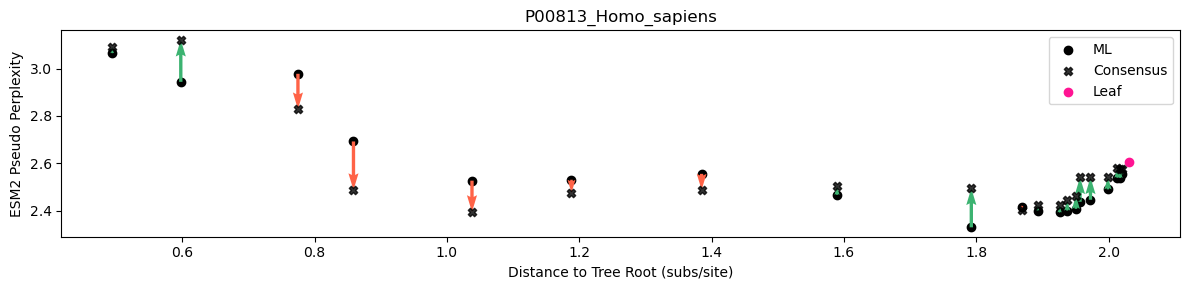

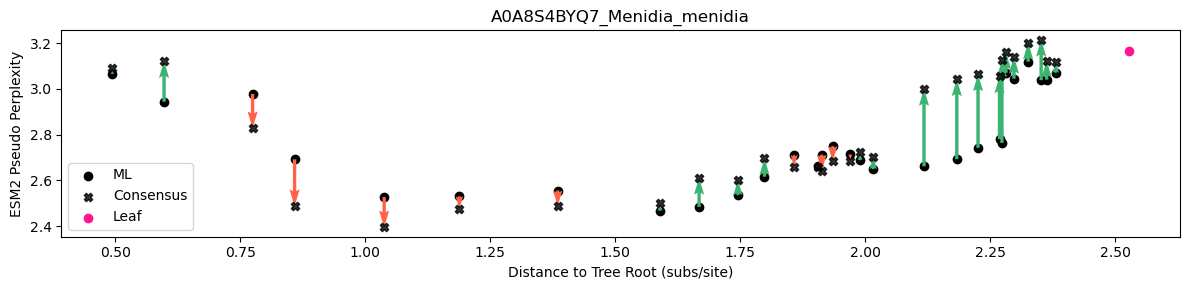

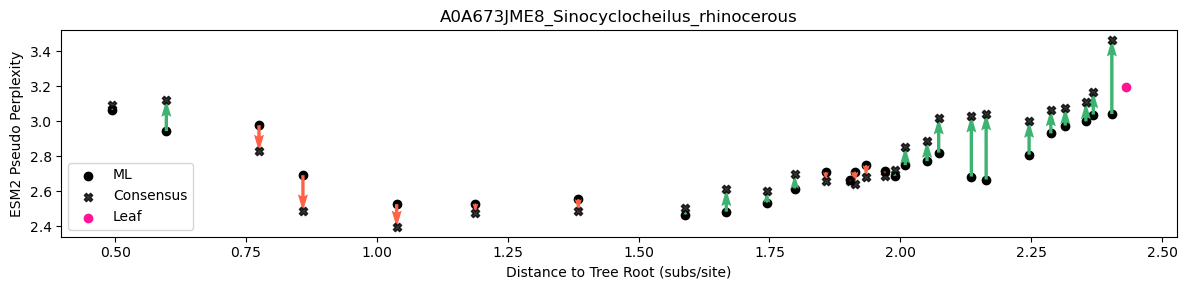

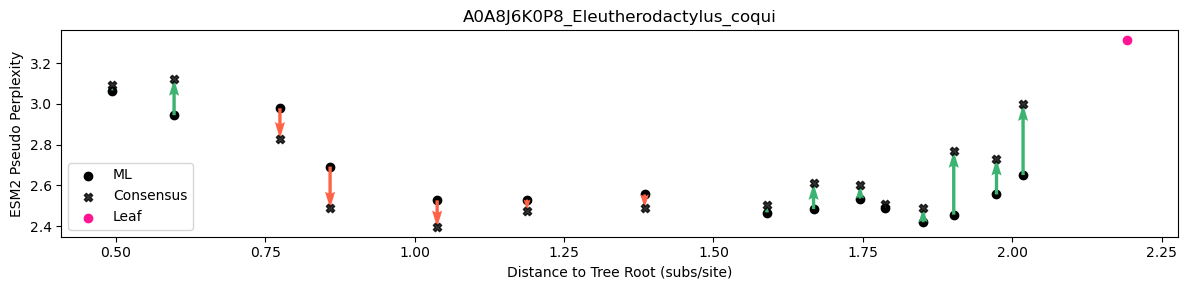

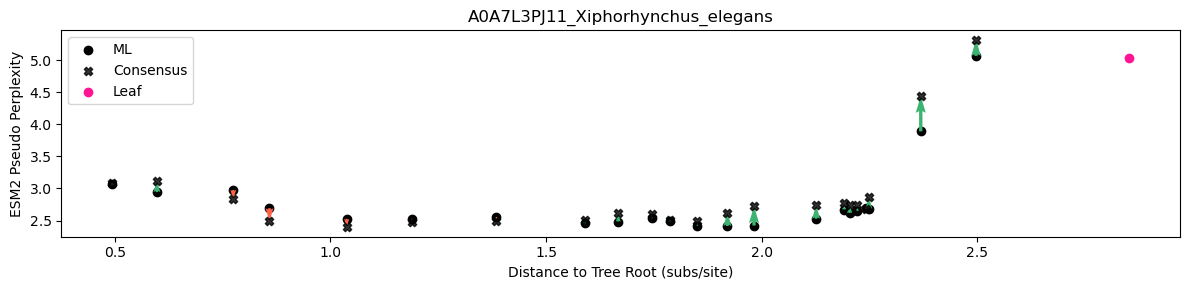

In [423]:
model_to_plot = model_dfs[3]

plot_evo_path_quiver(model_to_plot, tree, 'P00813_Homo_sapiens')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path_quiver(model_to_plot, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')
plot_evo_path_quiver(model_to_plot, tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')


### Results for smaller model 

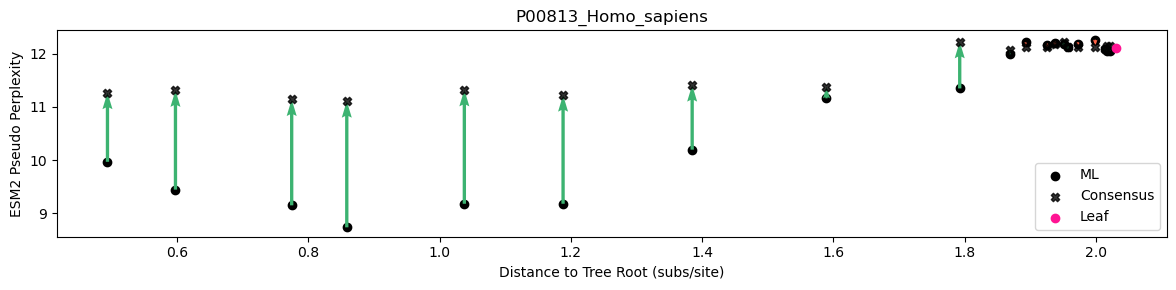

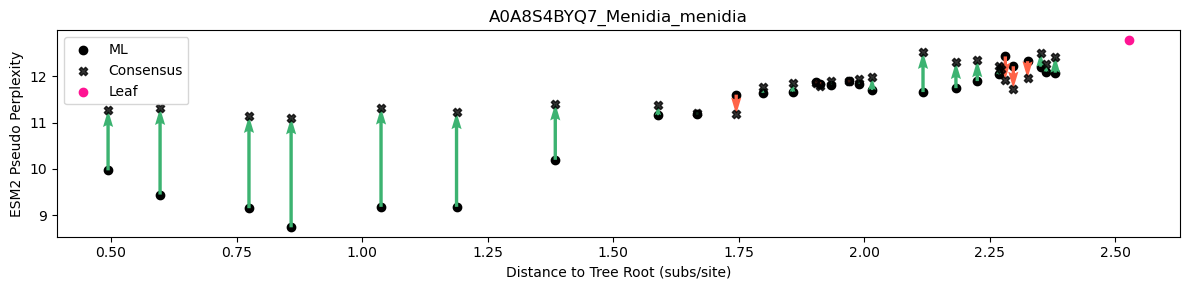

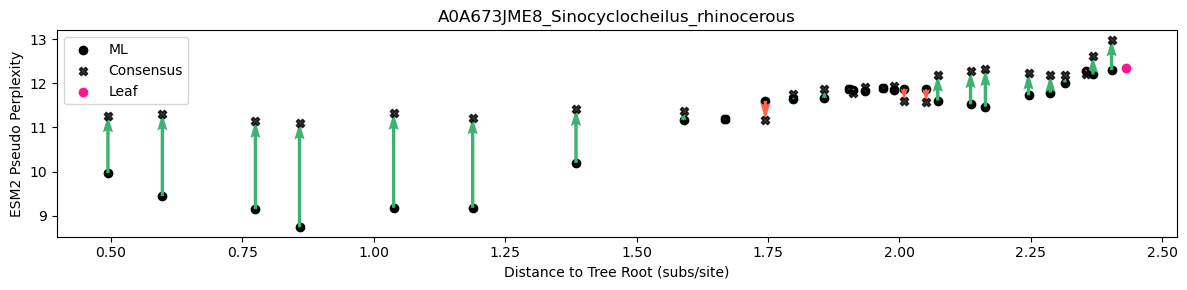

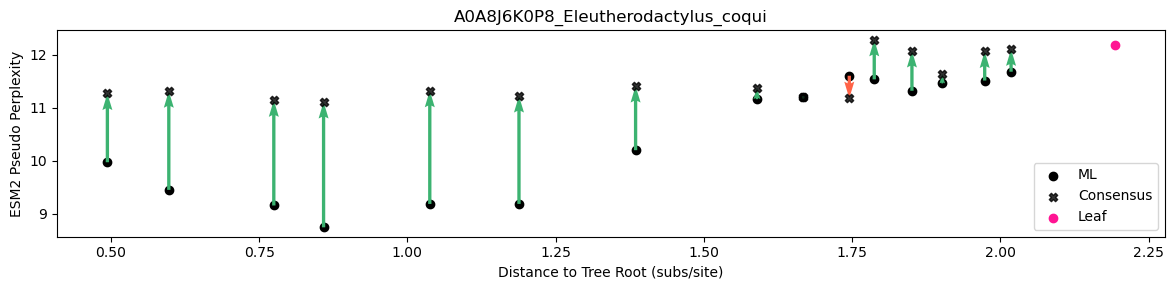

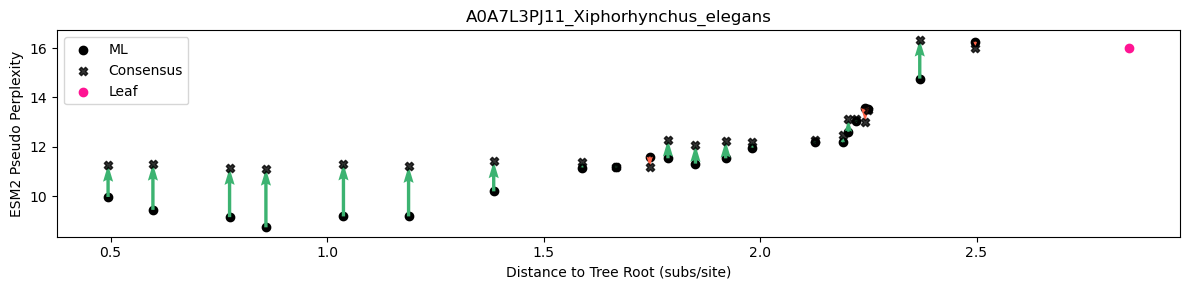

In [424]:
model_to_plot = model_dfs[0]

plot_evo_path_quiver(model_to_plot, tree, 'P00813_Homo_sapiens')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path_quiver(model_to_plot, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')
plot_evo_path_quiver(model_to_plot, tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')


## ESMfold tell us anything about these ancestors?

In [ ]:
### Measure ADA1 ESMfold scores

# get all nodes
all_nodes = []
extant_list = ['P00813_Homo_sapiens','A0A4U1F994_Monodon_monoceros', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A7L3PJ11_Xiphorhynchus_elegans']
for entry in extant_list:
    all_nodes.extend(get_node_labels_leaf_to_root(tree, entry))

all_nodes.extend(extant_list)
all_nodes = list(set(all_nodes))

# first get ESMfold structures
esmfold_folder = '/Users/isabel/Documents/ASR/temp_asr_plm/esmfold/'
with open(esmfold_folder + 'ADA1_seqs_for_esmfold.fa', 'w') as file:
    for index, row in all_scores.iterrows():
        if row['sequence_id'] in all_nodes:
            file.write(f">{row['sequence_id']}\n{row['sequence']}\n")


In [ ]:
import os
def extract_ca_plddt(pdb_file):
    """Extract CA atom pLDDT scores from a PDB file."""
    plddt_dict = {}
    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                chain_id = line[21].strip()
                resnum = int(line[22:26].strip())
                b_factor = float(line[60:66].strip())
                plddt_dict[(chain_id, resnum)] = b_factor
    return plddt_dict

folded_anc = ['esmfold/predicted_structures/' + file for file in os.listdir('esmfold/predicted_structures/')]
esmfold_scores_dict = {}
low_esm_fold_scores_dict = {}
threshold = 0.6
for entry in folded_anc:
    esmfold_scores_dict[entry.split('/')[-1].split('.')[0]] = float(np.mean(list(extract_ca_plddt(entry).values())))
    low_esm_fold_scores_dict[entry.split('/')[-1].split('.')[0]] =  len([x for x in list(extract_ca_plddt(entry).values()) if x < threshold])/len(list(extract_ca_plddt(entry).values()))

In [ ]:
len([x for x in list(extract_ca_plddt(entry).values()) if x > 0.9])/len(list(extract_ca_plddt(entry).values()))

In [ ]:
all_scores['esmfold_plddt'] = all_scores['sequence_id'].apply(lambda x: esmfold_scores_dict[x] if x in esmfold_scores_dict else np.nan)
all_scores['esmfold_low_plddt'] = all_scores['sequence_id'].apply(lambda x: low_esm_fold_scores_dict[x] if x in low_esm_fold_scores_dict else np.nan)

In [ ]:
all_scores

In [ ]:
def plot_evo_path_esmfold(scores_df, tree, leaf_name, labels = False):
    these_nodes = get_node_labels_leaf_to_root(tree, leaf_name)

    # Subset the relevant data
    for_plot = scores_df[scores_df['sequence_id'].isin(these_nodes)]

    plt.figure(figsize=(12, 3))

    # Scatter plot with color representing ML probability
    scatter = plt.scatter(
        for_plot['bl_to_root'],
        for_plot['esmfold_low_plddt'],
        c=for_plot['ML prob'],
        cmap='viridis_r',
        marker='o'
    )

    #Add labels for each point using the sequence_id
    if labels == True: 
        for i, row in for_plot.iterrows():
            plt.text(
                row['bl_to_root'],
                row['esmfold_low_plddt'],
                row['sequence_id'],
                fontsize=9,
                ha='right',
                va='bottom'
            )


    # Add the leaf point in pink
    x = calc_branch_length_to_root_leaf(tree, leaf_name)
    y = scores_df[scores_df['sequence_id'] == leaf_name]['esmfold_low_plddt'].to_list()[0]
    plt.scatter(x, y, color='deeppink', label='Leaf', zorder=10)

    # Add colorbar
    plt.colorbar(scatter, label='ASR Mean Posterior Probability')

    # Labels and layout
    plt.xlabel('Distance to Tree Root (subs/site)')
    plt.ylabel('ESMfold plddt')
    plt.title(leaf_name)
    plt.tight_layout()
    plt.show()

plot_evo_path_esmfold(all_scores, tree, 'P00813_Homo_sapiens')

In [ ]:
# make histogram of plddt scores instead of just mean


# # Extract pLDDT values
# node233_plddt = list(extract_ca_plddt('esmfold/predicted_structures/node233.pdb').values())
# human_plddt = list(extract_ca_plddt('esmfold/predicted_structures/p00813-homo-sapiens.pdb').values())
# node245_plddt = list(extract_ca_plddt('esmfold/predicted_structures/node245.pdb').values())

# # Combine all data to compute shared bins
# all_plddt = node233_plddt + human_plddt + node245_plddt
# min_val, max_val = min(all_plddt), max(all_plddt)
# bins = np.linspace(min_val, max_val, 21)  # 10 equal-width bins

# # Plot histograms with shared bins
# plt.hist(node233_plddt, bins=bins, alpha=0.6, label='node233')
# plt.hist(human_plddt, bins=bins, alpha=0.6, label='human')
# plt.hist(node245_plddt, bins=bins, alpha=0.6, label='node245')

# plt.ylabel('esmfold pLDDT count')
# plt.xlabel('pLDDT')
# plt.legend()
# plt.show()


# print (len([x for x in node233_plddt if x < 0.5]))
# print (len([x for x in node245_plddt if x < 0.5]))
# print (len([x for x in human_plddt if x < 0.5]))



In [ ]:
# plot plddt across protein

plt.figure(figsize=(12, 4))
plt.plot(node233_plddt, label='Node233')
plt.plot(human_plddt, label='Human')
plt.plot(node245_plddt, label='Node245')
plt.xlabel('Residue Position')
plt.ylabel('pLDDT')
plt.title('Residue-level Confidence from ESMFold')
plt.legend()
plt.tight_layout()
plt.show()


## Thornton epistasis paper provide any ground truth?


In [ ]:
thornton_esm = '/Users/isabel/Documents/Evolvability/thornton_data/thornton_anc.csv'
more_thornton = '/Users/isabel/Documents/Evolvability/thornton_data/thornton_more.csv'

thornton_df1 = pd.read_csv(thornton_esm)
thornton_df2 = pd.read_csv(more_thornton)

thornton_df = pd.concat([thornton_df1, thornton_df2], ignore_index=True)

# mapping nodes to names
node_mapping = {'AncSR1': '399', 'AncSR':'376', 'AncNR3':'332', 'AncSco':'392', 'AncPro':'379', 'AncSed':'391', 'AncAnn':'387', 'HumanGR': 'H_sapiens_GR', 'CteletaSR': 'C_teleta_ER'}

thornton_df['real_name'] = thornton_df['sequence_id'].apply(lambda x: 'node' + node_mapping[x] if 'Anc' in x else node_mapping[x] if 'node' not in x else x)
thornton_df = thornton_df[['real_name', 'pseudo_perplexity', 'sequence']]

# rename columns
thornton_df = thornton_df.rename(columns={'real_name': 'sequence_id'})
thornton_df


In [ ]:
# add branch lengths into table
orig_rooted_tree = '/Users/isabel/Documents/Evolvability/thornton_data/my_parsed_paml_outputs/ancestor_tree.txt'
thornton_tree = Phylo.read(orig_rooted_tree, 'newick')

thornton_df['bl_to_root'] = thornton_df['sequence_id'].apply(lambda x: 0 if x == 'node222' else calc_branch_length_to_root_node(thornton_tree, x[4:]) if 'node' in x else calc_branch_length_to_root_leaf(thornton_tree, x))

thornton_df


In [ ]:
# add ML probs
ml_probs_json = '/Users/isabel/Documents/Evolvability/thornton_data/my_parsed_paml_outputs/posterior_probabilities.json'

with open(ml_probs_json, "r") as f:
    probs_dict = json.load(f)

thornton_df['ML prob'] = thornton_df['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

In [ ]:
plot_evo_path(thornton_df, thornton_tree, 'H_sapiens_GR', labels = True)
plot_evo_path(thornton_df, thornton_tree, 'C_teleta_ER', labels = True)

In [ ]:
# Compare to consensus sequences

alignment_file = ''

name_conv_dict = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/recoding_dict.txt'
gap_dict_json = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/gap_positions.json'

consensus_seq_file = '/Users/isabel/Documents/ESM2/consensus_seqs.fa'

with open(consensus_seq_file, 'w') as file:
    for entry in ancestors_of_interest:
        consensus_seq = generate_node_consensus(tree, entry, alignment_file, name_conv_dict, gap_dict_json)
        name = entry + '_consensus'
        file.write('>' + name + '\n' + consensus_seq + '\n')



In [ ]:
# look at thornton fitness data

thornton_fitness_df = pd.read_csv('/Users/isabel/Documents/Evolvability/thornton_data/Supplementary files/dF.txt', sep = ' ')

# add in name of wt
mapping_df = pd.read_csv('/Users/isabel/Documents/Evolvability/thornton_data/Supplementary files/Notes.txt', sep = ':')
# rename 1st column
mapping_df.rename(columns = {mapping_df.columns[0]: 'anc_number'}, inplace = True)
mapping_df.rename(columns = {mapping_df.columns[1]: 'anc_name'}, inplace = True)
mapping_dict = mapping_df.set_index('anc_number')['anc_name'].to_dict()

# add new column that maps name from mapping_df to df
thornton_fitness_df['anc_name'] = thornton_fitness_df['PROT'].apply(lambda x: mapping_dict[str(x)])
thornton_fitness_df['anc_name'] = thornton_fitness_df['anc_name'].str.replace(' ', '')

# get rid of log10 and average
thornton_fitness_df['F1_actual'] = thornton_fitness_df['F1'].apply(lambda x: 10**float(x))
thornton_fitness_df['F2_actual'] = thornton_fitness_df['F2'].apply(lambda x: 10**float(x))
thornton_fitness_df['F3_actual'] = thornton_fitness_df['F3'].apply(lambda x: 10**float(x))
thornton_fitness_df['ave_F_actual'] = thornton_fitness_df[['F1_actual', 'F2_actual', 'F3_actual']].mean(axis=1)


#Identify wild-type rows
wt = thornton_fitness_df[thornton_fitness_df['WTAA'] == thornton_fitness_df['MTAA']].copy()
wt = wt[['anc_name', 'ave_F_actual']].rename(columns={'avg_fitness': 'WT_F_avg'})
wt = wt[~wt['anc_name'].str.contains('Alt')]

# average wt
wt = thornton_fitness_df[thornton_fitness_df['WTAA'] == thornton_fitness_df['MTAA']].copy()
result = wt.groupby('anc_name', as_index=False)['ave_F_actual'].mean()
result = result.rename(columns={'avg_fitness': 'ave_ave_fitness'})


result

In [ ]:


order_ctel = ['C.teletaSR', 'ScolecidSR', 'SedentarianSR', 'AnnelidSR', 'ProtostomeSR', 'AncSR', 'AncNR3']
order_human = ['HumanGR', 'AncSR1', 'AncSR', 'AncNR3']


for entry in order_human:
    print (entry, ':', result[result['anc_name'] == entry]['ave_F_actual'].to_list()[0])
    



In [ ]:
len(all_nodes)

In [ ]:
plt.hist(thornton_fitness_df['ave_F_actual'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Average Fitness')
plt.ylabel('Count')
plt.title('Histogram of avg_fitness')
plt.show()

## Thioredoxin dataset as ground truth?

In [ ]:
# load in perplexity scores

trx_8M = pd.read_csv('TRX_ASR_paper/Trx_8M.csv')
trx_8M = trx_8M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_8M'})

trx_35M = pd.read_csv('TRX_ASR_paper/Trx_35M.csv')
trx_35M = trx_35M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_35M'})

trx_150M = pd.read_csv('TRX_ASR_paper/Trx_150M.csv')
trx_150M = trx_150M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_150M'})

trx_650M = pd.read_csv('TRX_ASR_paper/Trx_650M.csv')
trx_650M = trx_650M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_650M'})

trx_3B = pd.read_csv('TRX_ASR_paper/Trx_3B.csv')
trx_3B = trx_3B[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_3B'})

# Merge all on sequence_id
trx_df = trx_8M.merge(trx_35M, on='sequence_id') \
               .merge(trx_150M, on='sequence_id') \
               .merge(trx_650M, on='sequence_id') \
               .merge(trx_3B, on='sequence_id')

# add in age and fitness scores
trx_fitness_df = pd.read_csv('TRX_ASR_paper/Trx_fitness.csv')
trx_fitness_df

trx_df = trx_df.merge(trx_fitness_df, on='sequence_id')

trx_df['sequence_id'] = trx_df['sequence_id'].apply(lambda x: x.replace(' ', ''))
trx_df


In [ ]:
plt.figure(figsize=(10, 6))
plot_list = ['LBCA_Trx', 'LPBCA_Trx', 'LGPCA_Trx', 'E_coli_Trx']
#plot_list =['AECA_Trx', 'LECA_Trx', 'LAFCA_Trx', 'Human_Trx']
plot_df = trx_df[trx_df['sequence_id'].isin(plot_list)].copy()

# Normalize pppl values (min-max) for each model size
pppl_cols = ['pppl_8M', 'pppl_35M', 'pppl_150M', 'pppl_650M', 'pppl_3B']
for col in pppl_cols:
    min_val = trx_df[col].min()
    max_val = trx_df[col].max()
    plot_df[col] = (plot_df[col] - min_val) / (max_val - min_val)

# Plot normalized values
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Age'], plot_df['pppl_8M'],     label='8M')
plt.scatter(plot_df['Age'], plot_df['pppl_35M'],    label='35M')
plt.scatter(plot_df['Age'], plot_df['pppl_150M'],   label='150M')
plt.scatter(plot_df['Age'], plot_df['pppl_650M'],   label='650M')
plt.scatter(plot_df['Age'], plot_df['pppl_3B'],     label='3B')

plt.xlabel('Age (Gyr)')
plt.ylabel('Normalized Pseudo-Perplexity')
plt.title('Normalized Pseudo-Perplexity vs Age for Different Model Sizes')
plt.legend(title='Model Size')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
trx_df

In [ ]:
plt.scatter(plot_df['Age'], plot_df['Tm'])

In [ ]:
plot_df